# Proyect 1: DMRG and Particle in a Box

### To do:
- make more graphics to analyse how the finite system alg. converges
- the warmup phase is 2 sites too long we have to leave 2 places left make it until L-1 (in general make suer the indices for every loop are correctly limited)
- set the matrix to hold types of float 64 for maximum precision
- Implement a rounding protocol 
- create the basis generation function using itertools
- Make sure that the units are ok
- implement a cost function to meassure the error


In [1]:
import numpy as np
import scipy.linalg as la
from itertools import combinations, combinations_with_replacement
import matplotlib.pyplot as plt

# 1.1 Density matrix computation

steps:

    1. Define Hamiltonian
    2. Choose system size and find the basis
    4. Compute the matrix elements
    5. Diagonalize the matrix
    6. Write Down the ground state as a matrix
    7. Compute the density matrix via matrix multiplication

### b) L = 4

Idea: Use the operators in matrix form to make the calculations

In [2]:
# definition of the operators
s_up = np.asarray([[0,1],[0,0]])
s_down = np.asarray([[0,0],[1,0]])
s_z = np.asarray([[1/2,0],[0,-1/2]])


In [3]:
def apply_operator(current_operator, next_operator,spin_chain, position):
    # applies the specified operators to the current and next place in the chain
    # args-> current_operator, next_operator: matrices representing the action on the current and 
    #        the next lattice site
    #         spin_chain: list of lists representing a basis vecotr
    #         position: index indicating the current position of the lattice
    # returns the transoformed spin chain
    spins_f = spin_chain.copy()
    # matrix multiplication only in the correct position of the basis vector
    spins_f[position] = list(np.matmul(current_operator,spin_chain[position]))
    spins_f[position+1] = list(np.matmul(next_operator,spin_chain[position+1]))    
    
    return spins_f

def calculate_matrix_term(spin_bra, spin_ket):
    # applies the heisenberg hamiltonian to each lattice site, for the hesinberg hamiltonian
    # we have 3 terms for each site.
    # args-> spin_bra: a list of lists representing the bra basis vector,
    #        spin_ket: a list of lists representing the ket basis vector
    # returns the matrix element as a number
    
    # save the spin chains just in case we need them latter
    sz_term = []
    # ket acted upon by first ladder operator product
    first_ladder = []
    # ket acted upon by second ladder operator product
    second_ladder = []
    eigen_values = []
    for i in range(0,len(spin_ket)-1):
        #Sz operator term
        transformed_spins = apply_operator(s_z,s_z,spin_ket,i)
        sz_term.append(transformed_spins)

        # First ladder operator term 
        transformed_spins = apply_operator(s_up,s_down,spin_ket,i)
        first_ladder.append(transformed_spins)

        # second ladder operator term
        transformed_spins = apply_operator(s_down,s_up,spin_ket,i)
        second_ladder.append(transformed_spins)

        # now we take the inner product with the basis Bra
        # to represent the inner product, sum the rows and then multiply all the elements to get the eigen value
        bracket = np.multiply(spin_bra,sz_term[i])
        eigen_values.append(np.prod(bracket.sum(1)))
        
        # remember that ladder operator terms have a 1/2 in front of them
        bracket = np.multiply(spin_bra,first_ladder[i])
        eigen_values.append(0.5*np.prod(bracket.sum(1)))

        bracket = np.multiply(spin_bra,second_ladder[i])
        eigen_values.append(0.5*np.prod(bracket.sum(1)))

    return np.sum(eigen_values)



Now we have to calculate all the matrix elements for the ground state part of the Hamiltonian. The ground state
is given by all the configurations corresponding to S=0

In [4]:
# Defining the ground state basis
basis_1 = [[1,0],[1,0], [0,1], [0,1]]
basis_2 = [[1,0],[0,1], [1,0], [0,1]]
basis_3 = [[1,0],[0,1], [0,1], [1,0]]
basis_4 = [[0,1],[1,0], [1,0], [0,1]]
basis_5 = [[0,1],[1,0], [0,1], [1,0]]
basis_6 = [[0,1],[0,1], [1,0], [1,0]]

basis_list = [ basis_1, basis_2, basis_3, basis_4, basis_5, basis_6]


In [5]:
# calculate each matrix element by iterating over the basis list two times
hamiltonian_matrix = np.zeros((len(basis_list), len(basis_list)))
# columns iteration
for i in range(len(basis_list)):
    # row iteration
    for j in range(len(basis_list)):
        hamiltonian_matrix[j,i] = calculate_matrix_term(basis_list[j],basis_list[i])

hamiltonian_matrix

array([[ 0.25,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.5 , -0.75,  0.5 ,  0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.5 , -0.25,  0.  ,  0.5 ,  0.  ],
       [ 0.  ,  0.5 ,  0.  , -0.25,  0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.5 ,  0.5 , -0.75,  0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.25]])

In [6]:
# matrix diagonalization
# .eig returns a tuple of vectors
g_eigenvalues, g_eigenvectors = la.eig(np.asmatrix(hamiltonian_matrix))
# save the lowest eigenvalue and eigenvector which represent the ground state
ground_index = g_eigenvalues.argmin()

print("Eigenvalues for the groundstate block")
print(g_eigenvalues)
print()

# We now choose the lowest eigen value since it corresponds to the ground state
print("chosen eigenvalue")
print(g_eigenvalues[ground_index])
print()
print("chosen eigenvector")
print(g_eigenvectors[:,ground_index])
chosen_eigenvector = g_eigenvectors[:,ground_index]

Eigenvalues for the groundstate block
[-1.6160254 +0.j -0.95710678+0.j  0.1160254 +0.j  0.75      +0.j
  0.45710678+0.j -0.25      +0.j]

chosen eigenvalue
(-1.6160254037844373+0j)

chosen eigenvector
[ 0.14942925 -0.55767754  0.40824829  0.40824829 -0.55767754  0.14942925]


Matrix decomposition. We now calculate $\psi_{ij}$ for the matrix representation of the ground state.
Remember that, since ground state is always at S = 0, **the matrix elements that correspond to another value of the spin have to be set to zero**.

We have to choose how to sepparate our gorund state in two systems.

We will use the eigen vector with the highest eigen values, since the rest of them tend to be very small

## for now we do it by hand

# RESARCH PYTHON PERMUTATIONS

In [7]:
# define the two system basis
A_1 = [[1,0],[1,0]]
A_2 = [[1,0],[0,1]]
A_3 = [[0,1],[1,0]]
A_4 = [[0,1],[0,1]]

A_basis = [A_1,A_2,A_3,A_4]
B_basis = [A_1,A_2,A_3,A_4]


In [8]:
# we now calculate the ground state matrix representation
psi_ij = np.zeros((len(A_basis), len(B_basis)))
#rows
for i in range(0,len(A_basis)):
    #columns
    for j in range(0,len(B_basis)):
        is_in_gbasis = A_basis[j]+B_basis[i] in basis_list
        if is_in_gbasis == True: 
            # save index of the basis vector to find the eigen value
            eigen_index = basis_list.index(A_basis[j]+B_basis[i])
            psi_ij[i,j] = chosen_eigenvector[eigen_index]

rho_reduced = np.asmatrix(psi_ij)* np.asmatrix(psi_ij).H

In [9]:
np.set_printoptions(precision=7)
psi_ij

array([[ 0.       ,  0.       ,  0.       ,  0.1494292],
       [ 0.       , -0.5576775,  0.4082483,  0.       ],
       [ 0.       ,  0.4082483, -0.5576775,  0.       ],
       [ 0.1494292,  0.       ,  0.       ,  0.       ]])

In [10]:
rho_reduced

matrix([[ 0.0223291,  0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.4776709, -0.4553418,  0.       ],
        [ 0.       , -0.4553418,  0.4776709,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.0223291]])

In [11]:
rho_reduced[-1,0]

0.0

In [12]:
np.sum([1,2,3,4])

10

Calculate the reduced density matrix via conjugate transposed

# 1.2 DMRG for particle in a box


In [13]:
def initialize_hamiltonian(size=4, periodic_boundary=False):
    # creates the initial discretized hamiltonian
    # size = 4 as default
    # periodic_boundary:  if False then only periodic boundaries
    # returns --> array representing the hamiltonian
    
    hamiltonian = np.asmatrix(np.zeros((size,size)))
    np.fill_diagonal(hamiltonian, 2)

    for i in range(0,size-1):
        # fill upper diagonal
        hamiltonian[i,i+1] = -1
        # fill lower diagonal
        hamiltonian[i+1,i] = -1
    
    # for periodc boundaries add -1s at opposite corners
    if periodic_boundary==True:
        hamiltonian[-1,0] = -1
        hamiltonian[0,-1] = -1     
     
    return hamiltonian

def update_hamiltonian(current_H, new_t12, new_h11, new_t34, new_h44):
    # updates the block hamiltonian to include the new matrix elements of the new basis
    # assumes that we have reflection symmetry so only 2 elements are needed
    # args---> current_H: Matrix representing the block hamiltonian from the last step
    #       new_t12, new_h11: scalars representing H11 and T12 matrix elements on the new basis, 
    # returns---> new_H: Matrix representing the new hamiltonian
    
    # System
    new_H = current_H.copy()
    new_H[0,0] = new_h11
    new_H[0,1] = new_t12
    new_H[1,0] = new_t12
    # environment
    new_H[2,3] = new_t34
    new_H[3,2] = new_t34
    new_H[3,3] = new_h44
    
    return new_H

def find_ground_state(hamiltonian):
    # diagonalize and get the ground state energy and vector
    # args--> hamiltonian: matrix to diagonalize
    # returns --> ground_state eigen value as scalar and ground state eigen vector as array
    eigen_values, eigen_vectors = la.eig(np.asmatrix(hamiltonian))
    ground_index = eigen_values.argmin()
    E_ground_state = np.real(eigen_values[ground_index])
    psi_ground_state = eigen_vectors[:,ground_index]
    
    if np.sum(psi_ground_state) < 0:
        psi_ground_state = np.multiply(psi_ground_state,-1)
    
    return np.real(E_ground_state), psi_ground_state

def update_basis(psi, H_bloc, Tblock ,is_right=False):
    # performs the basis projection to update superblock hamiltonian according to right or left block
    # args-> psi: array for ground state wave function. 
    #        H_block, Tblock: number representing the blocks that we want to update, if is_right=True
    #               they corrspond to environment, else they correspond to the system        
    #       is_right: Boolean,indicates wether right or left block
    # returns---> Hnew, Tnew, scalars representing the new components of the superblock
    
    # indices for the projection corresponding to the type of block
    first_index = 0
    second_index = 0
    new_basis = 0
    
    # if right block we take the last two indices
    if is_right:
        first_index = 2
        second_index = 3
        # normalize
        new_basis = 1.0/np.sqrt(psi[first_index]**2 + psi[second_index]**2) * \
                                    np.asmatrix([psi[first_index],psi[second_index]])
        a1 = new_basis[0,0]
        # note that a2 is the updated wave function at site i+1
        a2 = new_basis[0,1]
        # calculate the new blocks
        Hnew = (a2**2)*H_bloc + 2*(a1**2) + 2*a1*a2*Tblock
        Tnew = -a1
    
    else:
        first_index = 0
        second_index = 1
        # normalize
        new_basis = 1.0/np.sqrt(psi[first_index]**2 + psi[second_index]**2) * \
                                    np.asmatrix([psi[first_index],psi[second_index]])
        a1 = new_basis[0,0]
        # note that a2 is the updated wave function at site i+1
        a2 = new_basis[0,1]
        # calculate the new blocks
        Hnew = (a1**2)*H_bloc + 2*(a2**2) + 2*a1*a2*Tblock
        Tnew = -a2
    
    return Hnew, Tnew

def error_function(true_value, calculated_value):
    # return the squared error between true_value and calculated_value
    # args--> true_value, calculated_value: scalars
    return np.abs(calculated_value - true_value)**2

### c) Exact Diagonalization of Disctretized Hamiltonian

We now compute the exact ground state for systems of increasing sizes. We do this by diagonalizing the discretized hamiltonian

In [14]:
sistem_sizes = [16,32,64,100,128,256,512,1024]
# arrays for open boundaries
open_energies = []
open_states = []
# arrays for periodic boundaries
periodic_energies = []
periodic_states = []

for i in range(0,len(sistem_sizes)):
    # first for open boundary conditions
    h_open = initialize_hamiltonian(sistem_sizes[i])
    # now for periodic boundary conditions
    h_periodic = initialize_hamiltonian(sistem_sizes[i],periodic_boundary=True)
    # diagonalize the Hamiltonian and find ground state for both boundaries
    e_open, psi_open = find_ground_state(h_open)
    open_energies.append(e_open)
    open_states.append(psi_open)
    
    e_per, psi_per = find_ground_state(h_periodic)
    periodic_energies.append(e_per)
    periodic_states.append(psi_per)


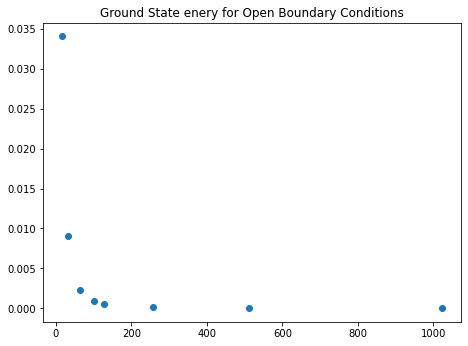

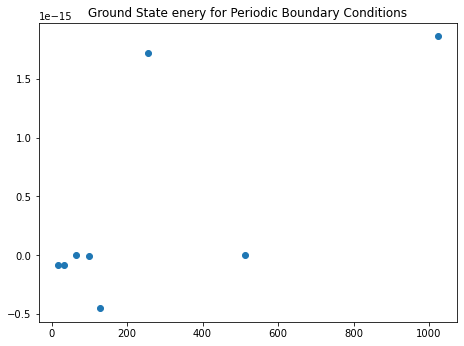

In [15]:
# ground state energy
plt.figure(figsize=(7.5,5.5))
plt.title("Ground State enery for Open Boundary Conditions")
plt.scatter(sistem_sizes,open_energies)

# ground state energy
plt.figure(figsize=(7.5,5.5))
plt.title("Ground State enery for Periodic Boundary Conditions")
plt.scatter(sistem_sizes,periodic_energies)

### e) DMRG for particle in  a box


**Warmup Phase**

For a system with L sites, start by using a system of $L^´= 4$ and grow it until it reaches full size. Since this system has reflection 
symmetry we can take it up to $L^´= L/2$. Remember that the idea is to diagonalize 4x4 matrices always.



In [16]:
# System size definition
L = 100
# vectors that save effective hamiltonians
H_list = list(np.zeros(L)) # superblock hamiltonian
system_blocks = list(np.zeros(L))
site_blocks = list(np.zeros(L))

# save ground state energies
E_list = []

# initialize the hamiltonian for the warmup phase
H = initialize_hamiltonian()
# initialize the blocks we only neew 2 since we have reflection symmetry
H11 = 2.0
T12 = -1.0
    
for i in range(0,int(L/2)):
    # diagonalize and get the ground state energy and vector
    E_ground, psi_ground = find_ground_state(H)
    H11, T12 = update_basis(psi_ground, H11, T12 ,is_right=False)
    
    # update the hamiltonian and get the next site hamiltonian
    H = update_hamiltonian(H, T12, H11, T12, H11)
    
    # save the effective hamiltonians
    H_list[i] = H
    system_blocks[i] = H[0,0]
    site_blocks[i] = H[0,1]
    
    E_list.append(E_ground)
    
# we can now reflect the right blocks to put them in the correct order
system_blocks[int(L/2):] = np.flip(system_blocks[:int(L/2)])
site_blocks[int(L/2):] = np.flip(site_blocks[:int(L/2)])

all_h = system_blocks
all_t = site_blocks

0.0026153797367574156


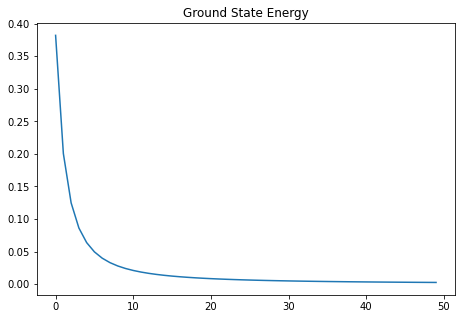

In [17]:
print(E_list[-1])
plt.figure(figsize=(7.5,5))
plt.title("Ground State Energy")
plt.plot(E_list)


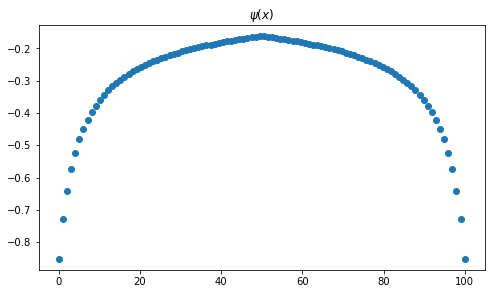

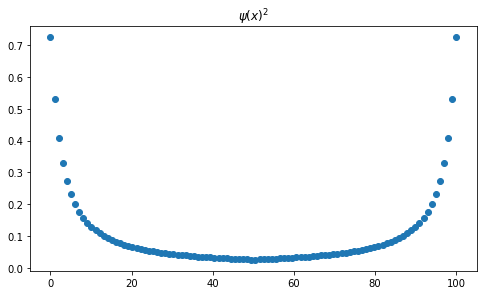

In [18]:
Lspace = np.linspace(0,100,100)
psi_infinite = np.asarray(all_t)

plt.figure(figsize=(8,4.5))
plt.title("$\psi(x)$")
plt.scatter(Lspace, psi_infinite)
plt.figure(figsize=(8,4.5))
plt.title("$\psi(x)^2$")
plt.scatter(Lspace,np.power(psi_infinite,2))

**Finite Algorithm Phase**

In [19]:
# number of sweeps
N_sweeps = 5
H_super = initialize_hamiltonian()
Exact_E = 0.000967435

for i in range(0,10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [20]:
# save the finite system data for comparisson
sweep_h = all_h
sweep_t = all_t
sweep_energies =[]
sweep_psi = []
ws = []
hs = []
# one sweeps is right to left and left to right
for k in range(0, N_sweeps):
    # apply reflection symmetry
    sweep_h[int(L/2)+1:] = np.flip(sweep_h[:int(L/2)-2])
    sweep_t[int(L/2)+1:] = np.flip(sweep_t[:int(L/2)-2])
    
    sweep_psi.append(sweep_t)
    
    # right to left
    for i in range(int(L/2)+1,2,-1):
    #for i in range(L-1,2,-1):
        # form the superblock H starting from the middle and sweeping to the left 
        H_super = update_hamiltonian(H_super, sweep_t[i-3], sweep_h[i-3], sweep_t[i], sweep_h[i])
        # find ground state and update bassi for the RIGHT block
        E_ground, psi_ground = find_ground_state(H_super)
        H44, T34 = update_basis(psi_ground, H_super[3,3], H_super[2,3] ,is_right=True)

        # update the chain
        sweep_h[i-1] = H44
        sweep_t[i-1] = T34
        
        hs.append(H44)
        ws.append(T34)

    # left to right
    for i in range(0, int(L/2)-2):
        # form the superblock H starting from the middle and sweeping to the left    
        H_super = update_hamiltonian(H_super, sweep_t[i], sweep_h[i], sweep_t[i+3], sweep_h[i+3])
        # find ground state and update basis for the RIGHT block
        E_ground, psi_ground = find_ground_state(H_super)
        H11, T12 = update_basis(psi_ground, H_super[0,0], H_super[0,1] ,is_right=False)

        # update the chain
        sweep_h[i+1] = H11
        sweep_t[i+1] = T12
        
        hs.append(H11)
        ws.append(T12)

    # append the energies after one sweep    
    sweep_energies.append(E_ground)


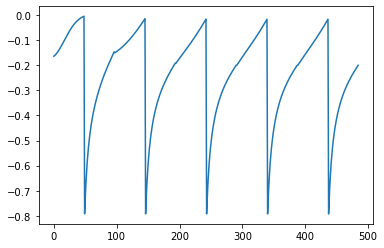

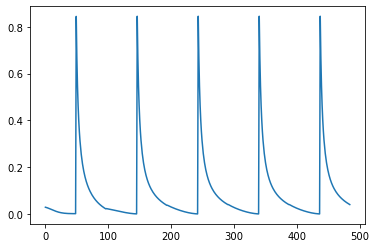

In [21]:
plt.figure()
plt.plot(ws)

plt.figure()
plt.plot(hs)

### Results for DMRG

In [22]:
for i in range(0,len(sweep_psi)):
    if sweep_psi[i] == sweep_psi[i]:
        print ("The lists are identical")
    else :
        print ("The lists are not identical")

The lists are identical
The lists are identical
The lists are identical
The lists are identical
The lists are identical


In [23]:
L_list = np.linspace(0,L,L)
q = np.pi/(L+1)
true_psi = np.sqrt(2/L)*np.sin(q*L_list)
psi_finite = sweep_t

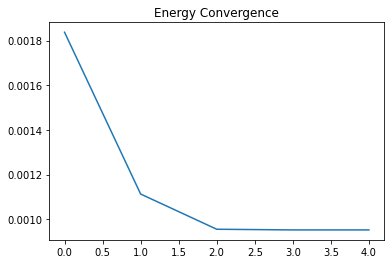

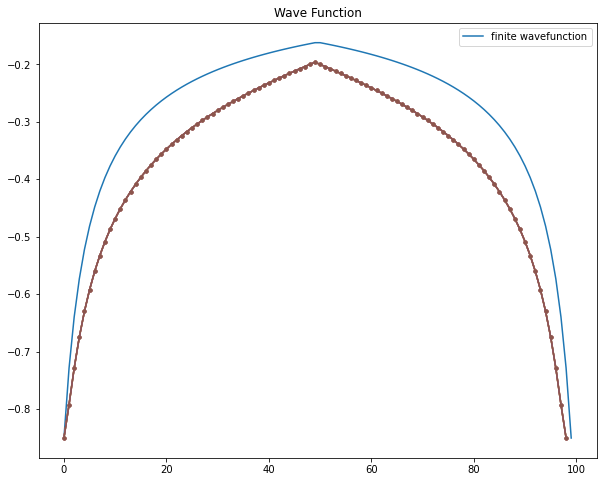

In [24]:
plt.figure()
plt.title('Energy Convergence')
plt.plot(sweep_energies)

plt.figure(figsize=(10,8))
plt.title('Wave Function')

#plt.plot(true_psi, label = 'true wavefunction')

plt.plot(psi_infinite, label = 'finite wavefunction')

for i in range(0,N_sweeps):
    plt.plot(sweep_psi[i], marker='.')
    
plt.legend()


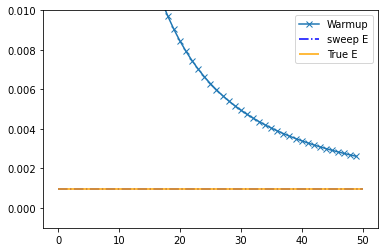

In [25]:
len(sweep_t)
plt.figure()
plt.hlines(sweep_energies[-1],0,50, color='b', label='sweep E', linestyles='dashdot')
plt.hlines(Exact_E,0,50, label='True E', color='orange')
plt.plot(E_list, label='Warmup', marker='x')
plt.ylim(-0.001,0.01)
plt.legend()

In [26]:
print(Exact_E)
sweep_energies

0.000967435


[0.001837126615464871,
 0.0011130864972712653,
 0.0009554803875245442,
 0.0009524798405834971,
 0.0009524788690060853]

In [27]:
sweep_psi[3]

[-0.85065080835204,
 -0.792297050994225,
 -0.7289478785906617,
 -0.6749836088806321,
 -0.630116693022068,
 -0.5925023488862655,
 -0.5605181245926678,
 -0.5329323712506497,
 -0.5088321907405217,
 -0.48753722672183936,
 -0.4685333475202307,
 -0.4514258221563786,
 -0.43590681206495113,
 -0.4217326968347318,
 -0.40870806383548586,
 -0.39667423435306626,
 -0.38550091399915354,
 -0.37508002550022695,
 -0.365321088706313,
 -0.3561477136698376,
 -0.34749490576527065,
 -0.3393069711284598,
 -0.3315358714409007,
 -0.3241399189782796,
 -0.31708273212720195,
 -0.3103323923108615,
 -0.30386075813033486,
 -0.29764290331024523,
 -0.2916566529440829,
 -0.2858821983929015,
 -0.2803017755745635,
 -0.2748993946909345,
 -0.26966061196201513,
 -0.2645723358726723,
 -0.2596226619366328,
 -0.25480073115120067,
 -0.25009660823384794,
 -0.2455011764571201,
 -0.24100604647512405,
 -0.23660347699637316,
 -0.23228630552909796,
 -0.2280478877255411,
 -0.22388204409604687,
 -0.21978301306340828,
 -0.215745409491880